In [1]:
from module import toSunpyMap, groupSunspots, getSRSTable

import numpy as np

from astropy.coordinates import SkyCoord

import sunpy.map
from sunpy.coordinates import frames, RotatedSunFrame


In [2]:
map = toSunpyMap('data/L2/imoa_03933_l2_20240323_13052647_emi1.fts.bz2', center_disk=True)

table = groupSunspots(map, threshold=0.01)

In [42]:
def assignNOAAToTable(table, map):
    srs_table = getSRSTable(map.date)
    
    date_obs = srs_table.meta['issued'].replace(hour=0, minute=0)
    
    srs_table = srs_table[srs_table['ID']=='I']
    coords = []
    for region in srs_table:
        point_noaa = SkyCoord(
                    region['Longitude'],
                    region['Latitude'], 
                    obstime=date_obs, 
                    observer='earth', 
                    frame=frames.HeliographicStonyhurst,
                    )

        diffrot_point = SkyCoord(RotatedSunFrame(base=point_noaa, rotated_time=map.date))
        transformed_diffrot_point = diffrot_point.transform_to(map.coordinate_frame)
        
        coords.append(transformed_diffrot_point)
        
    srs_table['coord'] = coords
        
    
    for idx, centroid in enumerate(table): 
        point = map.pixel_to_world(centroid['x'], centroid['y'])
        
        min_dist = np.inf
        for region in srs_table:
            dist  = region['coord'].separation(point).deg
        
            if min_dist > dist:
                min_dist = dist
                
                if min_dist<0.1:
                    table[idx]['noaa'] = region['Number']
            

    return table

In [43]:
table_with_noaa = assignNOAAToTable(table, map)

table_with_noaa

label,id,noaa,longitude,latitude,x,y
,,,deg,deg,pix,pix
uint16,int32,int32,float64,float64,float64,float64
1,--,13615,-10.18740210022139,-15.005612595371277,867.0,893.0
2,--,13615,-7.286744187993293,-14.488745843780167,911.0,902.0
3,--,13617,-37.13801798586445,-13.429583568347885,486.0,898.0
4,--,13615,-4.094509585359106,-13.895217720059867,960.0,912.0
5,--,13615,-13.93617882186902,-13.525296248056447,809.0,915.0
6,--,13615,-0.6688619022564808,-10.958468346920053,1013.0,959.0
7,--,13615,-6.601214445280391,-10.663217112367674,920.0,963.0
8,--,--,34.18676881907302,16.70440921558326,1516.0,1372.0


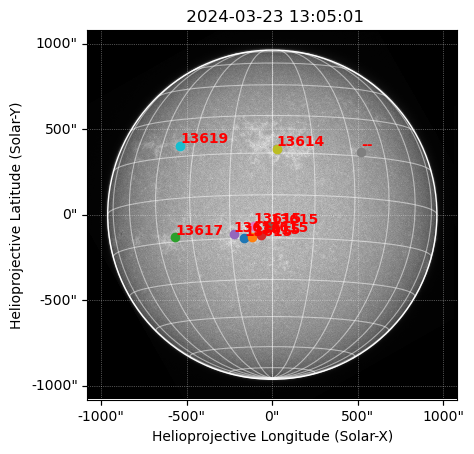

In [44]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection=map)
map.plot(axes=ax)
map.draw_limb(axes=ax)
map.draw_grid(axes=ax)

for region in table_with_noaa:
    ax.plot_coord(SkyCoord(region['longitude'],
                region['latitude'], 
                obstime=map.date, 
                observer='earth', 
                frame=frames.HeliographicStonyhurst,
                ).transform_to(map.coordinate_frame), 'o')
    ax.annotate( region['noaa'],
                (region['longitude'].value, region['latitude'].value),
                xycoords=ax.get_transform('heliographic_stonyhurst'),
                color='red',
                fontweight='bold',
                horizontalalignment='left', verticalalignment='bottom');